In [1]:
# Install necessary packages
!pip install albumentations==0.4.6
!pip install pytorch_lightning
!pip install torchmetrics  # For MeanAveragePrecision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 33.3 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65152 sha256=2f605cd7193ef5cbe829335c650095bf8e23280b15a9f0754e50837ae321481d
  Stored in directory: /root/.cache/pip/wheels/b3/d8/61/0fb4a147b5764c28c1a202331f8162e4234803c75d20fb2be5
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.5
    Uninstalling albumentations-2.0.5:
      Successfully uninstalled albumentations-2.0.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/

In [2]:
# Common imports
import os
import sys
from tqdm.notebook import tqdm
import numpy as np
from pathlib import Path
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import logging
import xml.etree.ElementTree as ET

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
from torchvision.ops.boxes import box_iou
from torchvision.models.detection._utils import Matcher
from torchvision.ops import nms, box_convert

# Albumentations for data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PyTorch Lightning imports
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# PyTorch Lightning imports
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Torchmetrics for mAP calculation
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Explicitly disable deterministic algorithms at the start
torch.use_deterministic_algorithms(False)

# Check and unset PL_DETERMINISTIC environment variable
if 'PL_DETERMINISTIC' in os.environ:
    print(f"Found PL_DETERMINISTIC={os.environ['PL_DETERMINISTIC']}. Unsetting it to avoid deterministic mode.")
    del os.environ['PL_DETERMINISTIC']

# Set up logging
logging.basicConfig(filename='/kaggle/working/annotation_issues.log', level=logging.WARNING, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path

annotation_dir = "/kaggle/input/ip102-dataset/Annotations"
annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith('.xml')]

issues = []

for xml_file in annotation_files:
    try:
        tree = ET.parse(os.path.join(annotation_dir, xml_file))
        root = tree.getroot()

        # Get image dimensions
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)

        # Check each object
        for obj in root.findall('object'):
            class_id = int(obj.find('name').text)
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            # Validate class ID
            if not (0 <= class_id <= 101):
                issues.append(f"{xml_file}: Invalid class ID {class_id} (must be 0 to 101)")

            # Validate coordinates
            if not (xmin < xmax):
                issues.append(f"{xml_file}: Invalid bbox, xmin ({xmin}) >= xmax ({xmax})")
            if not (ymin < ymax):
                issues.append(f"{xml_file}: Invalid bbox, ymin ({ymin}) >= ymax ({ymax})")
            if not (0 <= xmin < xmax <= width):
                issues.append(f"{xml_file}: Bbox x out of bounds: xmin={xmin}, xmax={xmax}, width={width}")
            if not (0 <= ymin < ymax <= height):
                issues.append(f"{xml_file}: Bbox y out of bounds: ymin={ymin}, ymax={ymax}, height={height}")

    except Exception as e:
        issues.append(f"{xml_file}: Failed to parse XML - {str(e)}")

# Report issues
if issues:
    print("Found issues in annotations:")
    for issue in issues:
        print(issue)
else:
    print("All annotations appear valid!")


Found issues in annotations:
IP087000986.xml: Failed to parse XML - junk after document element: line 27, column 0
IP046000898.xml: Invalid bbox, xmin (14.0) >= xmax (14.0)
IP046000898.xml: Bbox x out of bounds: xmin=14.0, xmax=14.0, width=240


In [4]:

# Define the Dataset Class for IP102 with Pascal VOC XML
class IP102Dataset(Dataset):
    """A dataset class for the IP102 dataset in Pascal VOC XML format."""

    def __init__(self, image_dir, annotation_dir, image_list_file, transform=None, is_test=False):
        """
        Args:
            image_dir (string): Directory with images (e.g., /kaggle/input/ip102-dataset/JPEGImages).
            annotation_dir (string): Directory with XML annotations (e.g., /kaggle/input/ip102-dataset/Annotations).
            image_list_file (string): Path to trainval.txt or test.txt with image filenames.
            transform (callable, optional): Optional data augmentation to be applied on a sample.
            is_test (bool): If True, skips loading annotations (for test set inference).
        """
        self.image_dir = Path(image_dir)
        self.annotation_dir = Path(annotation_dir)
        self.transform = transform
        self.is_test = is_test

        # Load image list from trainval.txt or test.txt
        with open(image_list_file, 'r') as f:
            self.image_list = [line.strip() + '.jpg' for line in f.readlines()]

        # Validate annotations during initialization (for training/validation only)
        if not self.is_test:
            valid_images = []
            for img_name in self.image_list:
                annotation_path = str(self.annotation_dir / (img_name.replace('.jpg', '.xml')))
                if os.path.exists(annotation_path):
                    try:
                        tree = ET.parse(annotation_path)
                        root = tree.getroot()
                        width = int(root.find('size/width').text)
                        height = int(root.find('size/height').text)
                        valid = True
                        for obj in root.findall('object'):
                            bbox = obj.find('bndbox')
                            xmin = float(bbox.find('xmin').text)
                            ymin = float(bbox.find('ymin').text)
                            xmax = float(bbox.find('xmax').text)
                            ymax = float(bbox.find('ymax').text)
                            # Check for zero-sized boxes
                            if xmin >= xmax or ymin >= ymax:
                                logging.warning(f"Skipping {img_name}: Invalid bbox (xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax})")
                                valid = False
                                break
                            # Check bounds
                            if not (0 <= xmin < xmax <= width and 0 <= ymin < ymax <= height):
                                logging.warning(f"Skipping {img_name}: Bbox out of bounds (xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}, width={width}, height={height})")
                                valid = False
                                break
                        if valid:
                            valid_images.append(img_name)
                    except ET.ParseError as e:
                        logging.warning(f"Skipping {img_name}: Failed to parse XML - {str(e)}")
                        continue
                else:
                    logging.warning(f"Skipping {img_name}: Annotation file not found")
                    continue
            self.image_list = valid_images
            print(f"Loaded {len(self.image_list)} valid images after filtering")

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = str(self.image_dir / img_name)
        annotation_path = str(self.annotation_dir / (img_name.replace('.jpg', '.xml')))

        # Robust RGB loading
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Ensures 3-channel image
        if img is None:
            raise FileNotFoundError(f"Image not found or corrupted: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load annotations from XML (skip for test set)
        bboxes, labels = [], []
        if not self.is_test:
            try:
                tree = ET.parse(annotation_path)
                root = tree.getroot()
                width = int(root.find('size/width').text)
                height = int(root.find('size/height').text)
                for obj in root.findall('object'):
                    class_id = int(obj.find('name').text)
                    bbox = obj.find('bndbox')
                    xmin = float(bbox.find('xmin').text)
                    ymin = float(bbox.find('ymin').text)
                    xmax = float(bbox.find('xmax').text)
                    ymax = float(bbox.find('ymax').text)

                    # Validate and fix bbox
                    if xmin >= xmax:
                        xmax = xmin + 1  # Ensure positive width
                        logging.warning(f"Adjusted bbox in {img_name}: xmin={xmin}, xmax={xmax}")
                    if ymin >= ymax:
                        ymax = ymin + 1  # Ensure positive height
                        logging.warning(f"Adjusted bbox in {img_name}: ymin={ymin}, ymax={ymax}")
                    # Clamp coordinates to image bounds
                    xmin = max(0, xmin)
                    ymin = max(0, ymin)
                    xmax = min(width, xmax)
                    ymax = min(height, ymax)

                    bboxes.append([xmin, ymin, xmax, ymax])
                    labels.append(class_id + 1)  # Class 0 = background
            except ET.ParseError as e:
                logging.warning(f"Failed to parse {img_name} at runtime: {str(e)}. Returning empty annotations.")
                bboxes, labels = [], []  # Fallback to empty annotations

        if self.transform:
            try:
                transformed = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = transformed["image"]
                bboxes = transformed["bboxes"]
                labels = transformed["class_labels"]
            except Exception as e:
                print(f"[Transform Error] {img_path} -> {e}")
                img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0  # Fallback

        if len(bboxes) > 0:
            bboxes = torch.tensor(bboxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.long)
        else:
            bboxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.long)

        # Check shape
        assert img.shape[0] == 3, f"Expected 3-channel image, got {img.shape}"

        return img, bboxes, labels, img_name

In [5]:
# Define Data Augmentation
train_transform = A.Compose([
    A.LongestMaxSize(1024),
    A.PadIfNeeded(1024, 1024, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.4),
    A.Rotate(limit=45, p=0.5),
    A.RandomScale(scale_limit=(0.1, 0.5), p=0.6),
    A.RandomCrop(height=768, width=768, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.5),
    A.HueSaturationValue(hue_shift_limit=25, sat_shift_limit=35, val_shift_limit=25, p=0.4),
    A.CoarseDropout(min_holes=4, max_holes=8, max_height=32, max_width=32, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_area=20))

val_test_transform = A.Compose([
    A.LongestMaxSize(1024),
    A.PadIfNeeded(1024, 1024, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [6]:
# Set Up the Dataset and DataLoader
image_dir = "/kaggle/input/ip102-dataset/JPEGImages"
annotation_dir = "/kaggle/input/ip102-dataset/Annotations"
trainval_list = "/kaggle/input/ip102-dataset/trainval.txt"
test_list = "/kaggle/input/ip102-dataset/test.txt"

In [7]:
# Load trainval dataset and split into train and val
trainval_dataset = IP102Dataset(
    image_dir=image_dir,
    annotation_dir=annotation_dir,
    image_list_file=trainval_list,
    transform=None  # We'll apply transform after splitting
)

# Split trainval into train and val (90% train, 10% val)
train_size = int(0.9 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

# Apply transforms to splits
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform

# Test dataset
test_dataset = IP102Dataset(
    image_dir=image_dir,
    annotation_dir=annotation_dir,
    image_list_file=test_list,
    transform=val_test_transform,
    is_test=True
)

Loaded 15176 valid images after filtering


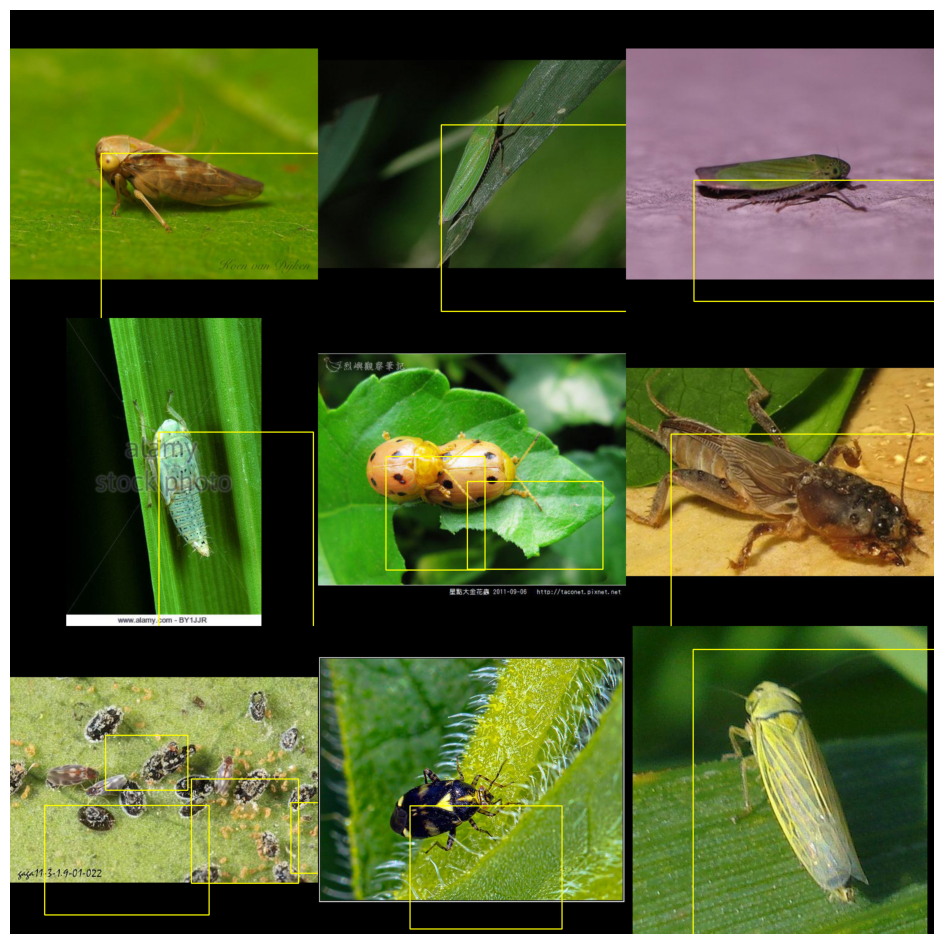

In [8]:
# Sanity Check of the Train Dataset
hlines = []
for i in range(3):
    vlines = []
    for j in range(3):
        idx = random.randint(0, len(train_dataset) - 1)
        img, bboxes, labels, _ = train_dataset[idx]

        # Convert tensor to NumPy image
        img = img.permute(1, 2, 0).numpy()  # CHW -> HWC
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        img = (img * 255).astype(np.uint8)

        # Make image shape consistent (force resize to 768x768)
        img = cv2.resize(img, (768, 768))

        for bbox in bboxes:
            x1, y1, x2, y2 = map(int, bbox)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 0), 2)

        vlines.append(img)

    hline = cv2.vconcat(vlines)
    hlines.append(hline)

final_img = cv2.hconcat(hlines)
plt.figure(figsize=(12, 12))
plt.imshow(final_img)
plt.axis("off")
plt.show()

In [9]:
# Define Collate Function for DataLoader
def collate_fn(batch):
    """
    Since each image may have a different number of objects, we need a collate function.

    :param batch: an iterable of N sets from __getitem__()
    :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and image names
    """
    images = list()
    boxes = list()
    labels = list()
    img_names = list()

    for img, bboxes, lbls, name in batch:
        images.append(img)
        boxes.append(bboxes)
        labels.append(lbls)
        img_names.append(name)
    images = torch.stack(images, dim=0)

    return images, boxes, labels, img_names

# Set Up DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

In [10]:
# Test DataLoader
batch = next(iter(train_dataloader))

In [11]:
# Define Faster R-CNN Model with PyTorch Lightning
seed_everything(25081992)

class FasterRCNN(LightningModule):
    def __init__(self, n_classes):
        super().__init__()
        self.detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = self.detector.roi_heads.box_predictor.cls_score.in_features
        self.detector.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
        self.lr = 1e-4
        self.batch_size = 4  # Explicitly define batch size

        # COCO-style mAP
        self.val_metric = MeanAveragePrecision(class_metrics=False)

    def forward(self, imgs, targets=None):
        return self.detector(imgs, targets) if self.training else self.detector(imgs)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        imgs, boxes, labels, _ = batch
        imgs = [img.to(self.device) for img in imgs]
        targets = [{"boxes": b.to(self.device), "labels": l.to(self.device)} for b, l in zip(boxes, labels)]

        loss_dict = self.detector(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, boxes, labels, _ = batch
        imgs = [img.to(self.device) for img in imgs]
        targets = [{"boxes": b.to(self.device), "labels": l.to(self.device)} for b, l in zip(boxes, labels)]

        preds = self.detector(imgs)

        # Format required by torchmetrics: list of dicts with boxes, scores, labels
        self.val_metric.update(preds, targets)

    def on_validation_epoch_end(self):
        metrics = self.val_metric.compute()
        self.log("mAP_50", metrics["map_50"], prog_bar=True, batch_size=self.batch_size)
        self.log("mAP_50_95", metrics["map"], prog_bar=True, batch_size=self.batch_size)
        self.val_metric.reset()

    def test_step(self, batch, batch_idx):
        imgs, _, _, img_names = batch
        imgs = [img.to(self.device) for img in imgs]
        preds = self.detector(imgs)

        # Store predictions for submission
        for pred, img_name in zip(preds, img_names):
            boxes = pred["boxes"].cpu().numpy()
            scores = pred["scores"].cpu().numpy()
            labels = pred["labels"].cpu().numpy()

            # Filter predictions with confidence threshold
            conf_threshold = 0.5
            mask = scores >= conf_threshold
            boxes = boxes[mask]
            scores = scores[mask]
            labels = labels[mask]

            # Convert to submission format (if needed)
            self.test_predictions.append({
                "image_name": img_name.replace('.jpg', ''),
                "boxes": boxes,
                "scores": scores,
                "labels": labels - 1  # Convert back to 0-based class IDs
            })

    def on_test_epoch_start(self):
        self.test_predictions = []

    def on_test_epoch_end(self):
        # Save predictions to a CSV file
        output_dir = "/kaggle/working/test_predictions"
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, "predictions.csv")

        # Format predictions as a DataFrame
        records = []
        for pred in self.test_predictions:
            image_name = pred["image_name"]
            boxes = pred["boxes"]
            scores = pred["scores"]
            labels = pred["labels"]

            if len(boxes) == 0:
                box_string = "no_box"
            else:
                box_strings = []
                for box, label in zip(boxes, labels):
                    # Format: class_id xmin ymin xmax ymax
                    box_str = f"{int(label)} {int(box[0])} {int(box[1])} {int(box[2])} {int(box[3])}"
                    box_strings.append(box_str)
                box_string = ";".join(box_strings)

            records.append({
                "image_name": image_name,
                "PredString": box_string
            })

        df = pd.DataFrame(records)
        df.to_csv(output_file, index=False)
        print(f"Test predictions saved to {output_file}")

In [12]:
# Initialize Model (102 pest classes + 1 background class)
detector = FasterRCNN(n_classes=103)  # 102 classes + background

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 231MB/s]


In [13]:
#Set Up Early Stopping and Trainer
early_stop_callback = EarlyStopping(
    monitor='mAP_50',
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode='max'
)

checkpoint_callback = ModelCheckpoint(
    monitor='mAP_50',
    dirpath='/kaggle/working/checkpoints',
    filename='faster_rcnn_ip102-{epoch:02d}-{mAP_50:.2f}',
    save_top_k=1,
    mode='max',
)

trainer = Trainer(
    accelerator="gpu",  # Use GPU
    devices=1,         # Number of GPUs
    max_epochs=10,
    deterministic=False,  # Explicitly disable deterministic mode
    callbacks=[early_stop_callback, checkpoint_callback]
)

# Train the Model
trainer.fit(detector, train_dataloader, val_dataloader)

# Save the Model
torch.save(detector.state_dict(), "/kaggle/working/faster_rcnn_ip102.pth")
print("Model saved to /kaggle/working/faster_rcnn_ip102.pth")


2025-06-17 20:18:28.172065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750191508.400832      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750191508.465658      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Model saved to /kaggle/working/faster_rcnn_ip102.pth


In [14]:
# Run Inference on Test Set
trainer.test(detector, test_dataloader)

Testing: |          | 0/? [00:00<?, ?it/s]

Test predictions saved to /kaggle/working/test_predictions/predictions.csv


[{}]